# Cart-Pole

In [1]:
import gym
import numpy as np
from matplotlib import pyplot as plt
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam

/home/sitibanc/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Define Class

In [13]:
# This is Policy Gradient agent for the Cartpole
# In this example, we use REINFORCE algorithm which uses monte-carlo update rule


class REINFORCEAgent:
    def __init__(self, state_size, action_size, learning_rate=1e-2, use_render=True):
        self.render = use_render
        # get size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # These are hyper parameters for the Policy Gradient
        self.learning_rate = learning_rate

        # create model for policy network
        self.model = self.build_model()

        # lists for the states, actions and rewards
        self.states, self.actions, self.rewards = [], [], []

    # approximate policy using Neural Network
    # state is input and probability of each action is output of network
    def build_model(self):
        model = Sequential()
        model.add(Dense(16, input_dim=self.state_size,
                        activation='relu', kernel_initializer='glorot_uniform', name='fc1'))
        model.add(Dense(8, activation='relu',
                        kernel_initializer='glorot_uniform', name='fc2'))
        model.add(Dense(self.action_size, activation='softmax',
                        kernel_initializer='glorot_uniform', name='output'))
        model.summary()
        # Using categorical crossentropy as a loss is a trick to easily
        # implement the policy gradient. Categorical cross entropy is defined
        # H(p, q) = sum(p_i * log(q_i)). For the action taken, a, you set
        # p_a = advantage. q_a is the output of the policy network, which is
        # the probability of taking the action a, i.e. policy(s, a).
        # All other p_i are zero, thus we have H(p, q) = A * log(policy(s, a))
        model.compile(loss='categorical_crossentropy',
                      optimizer=Adam(lr=self.learning_rate))
        return model

    # using the output of policy network, pick action stochastically
    def get_action(self, state):
        policy = self.model.predict(state, batch_size=1).flatten()
        return np.random.choice(self.action_size, 1, p=policy)[0]

    # In Policy Gradient, Q function is not available.
    # Instead agent uses sample returns for evaluating policy
    def discount_rewards(self, rewards):
        discounted_rewards = np.zeros_like(rewards)
        running_add = 0
        for t in reversed(range(0, len(rewards))):
            running_add = running_add * self.discount_factor + rewards[t]
            discounted_rewards[t] = running_add

        return discounted_rewards

    # save <s, a ,r> of each step
    def append_sample(self, state, action, reward):
        self.states.append(state)
        self.rewards.append(reward)
        self.actions.append(action)

    # update policy network every episode
    def train_model(self, counter, update_interval):
        # =========================
        # Get multiple trajectories
        # =========================
        counter = 0
        update_inputs_list, advantanges_list = [], []
        
        episode_length = len(self.states)

        update_inputs = np.zeros((episode_length, self.state_size))
        advantages = np.zeros((episode_length, self.action_size))

        for i in range(episode_length):
            update_inputs[i] = self.states[i]
            advantages[i][self.actions[i]] = len(self.actions)

        update_inputs_list.append(update_inputs)
        advantanges_list.append(advantages)
        # reset list for next episode (trajectory)
        self.states, self.actions, self.rewards = [], [], []
        
        # =========================
        # Update network parameters
        # =========================
        if counter == update_interval:
            print("Updating Policy...")
            # list to array
            update_inputs_list = np.concatenate(update_inputs_list)
            advantanges_list = np.concatenate(advantanges_list)
            # advantanges_list - baseline
            advantanges_list -= np.mean(np.max(advantanges_list, axis=-1))
            # Standardize
            advantanges_list -= np.mean(advantanges_list)
            advantanges_list /= np.std(advantanges_list)
            # Train model
            self.model.fit(update_inputs_list, advantanges_list, batch_size=128, epochs=1)
            # reset variables
            update_inputs_list, advantanges_list = [], []

## Main

### Setup

In [14]:
env = gym.make('CartPole-v0')
# Game Over 條件設定
env = env.unwrapped
env.theta_threshold_radians = 90 * 2 * np.pi / 360    # 向左或右傾斜90度
env.x_threshold = 2.4    # 超出遊戲範圍2.4
# get size of state and action from environment
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# make REINFORCE agent
agent = REINFORCEAgent(state_size, action_size, use_render=False)

scores = []
update_inputs_list, advantanges_list = [], []

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc1 (Dense)                  (None, 16)                80        
_________________________________________________________________
fc2 (Dense)                  (None, 8)                 136       
_________________________________________________________________
output (Dense)               (None, 2)                 18        
Total params: 234
Trainable params: 234
Non-trainable params: 0
_________________________________________________________________


### Training

episode: 1   score: 29.0
episode: 2   score: 59.0
episode: 3   score: 59.0
episode: 4   score: 75.0
episode: 5   score: 49.0
episode: 6   score: 33.0
episode: 7   score: 40.0
episode: 8   score: 27.0
episode: 9   score: 49.0
episode: 10   score: 42.0
episode: 11   score: 34.0
episode: 12   score: 28.0
episode: 13   score: 48.0
episode: 14   score: 49.0
episode: 15   score: 37.0
episode: 16   score: 49.0
episode: 17   score: 36.0
episode: 18   score: 31.0
episode: 19   score: 28.0
episode: 20   score: 56.0
episode: 21   score: 37.0
episode: 22   score: 29.0
episode: 23   score: 29.0
episode: 24   score: 47.0
episode: 25   score: 26.0
episode: 26   score: 59.0
episode: 27   score: 77.0
episode: 28   score: 56.0
episode: 29   score: 78.0
episode: 30   score: 51.0
episode: 31   score: 83.0
episode: 32   score: 81.0
episode: 33   score: 29.0
episode: 34   score: 61.0
episode: 35   score: 31.0
episode: 36   score: 32.0
episode: 37   score: 31.0
episode: 38   score: 55.0
episode: 39   score: 

episode: 313   score: 28.0
episode: 314   score: 60.0
episode: 315   score: 30.0
episode: 316   score: 30.0
episode: 317   score: 42.0
episode: 318   score: 53.0
episode: 319   score: 45.0
episode: 320   score: 62.0
episode: 321   score: 34.0
episode: 322   score: 48.0
episode: 323   score: 55.0
episode: 324   score: 23.0
episode: 325   score: 32.0
episode: 326   score: 33.0
episode: 327   score: 31.0
episode: 328   score: 66.0
episode: 329   score: 31.0
episode: 330   score: 52.0
episode: 331   score: 46.0
episode: 332   score: 35.0
episode: 333   score: 66.0
episode: 334   score: 43.0
episode: 335   score: 24.0
episode: 336   score: 28.0
episode: 337   score: 53.0
episode: 338   score: 39.0
episode: 339   score: 31.0
episode: 340   score: 41.0
episode: 341   score: 32.0
episode: 342   score: 29.0
episode: 343   score: 30.0
episode: 344   score: 54.0
episode: 345   score: 46.0
episode: 346   score: 39.0
episode: 347   score: 50.0
episode: 348   score: 32.0
episode: 349   score: 31.0
e

episode: 624   score: 28.0
episode: 625   score: 30.0
episode: 626   score: 26.0
episode: 627   score: 42.0
episode: 628   score: 53.0
episode: 629   score: 40.0
episode: 630   score: 59.0
episode: 631   score: 30.0
episode: 632   score: 48.0
episode: 633   score: 55.0
episode: 634   score: 26.0
episode: 635   score: 43.0
episode: 636   score: 84.0
episode: 637   score: 86.0
episode: 638   score: 26.0
episode: 639   score: 37.0
episode: 640   score: 50.0
episode: 641   score: 28.0
episode: 642   score: 28.0
episode: 643   score: 28.0
episode: 644   score: 35.0
episode: 645   score: 49.0
episode: 646   score: 55.0
episode: 647   score: 50.0
episode: 648   score: 49.0
episode: 649   score: 40.0
episode: 650   score: 38.0
episode: 651   score: 29.0
episode: 652   score: 30.0
episode: 653   score: 45.0
episode: 654   score: 33.0
episode: 655   score: 32.0
episode: 656   score: 57.0
episode: 657   score: 40.0
episode: 658   score: 33.0
episode: 659   score: 54.0
episode: 660   score: 46.0
e

episode: 936   score: 66.0
episode: 937   score: 40.0
episode: 938   score: 40.0
episode: 939   score: 48.0
episode: 940   score: 25.0
episode: 941   score: 34.0
episode: 942   score: 28.0
episode: 943   score: 47.0
episode: 944   score: 36.0
episode: 945   score: 33.0
episode: 946   score: 37.0
episode: 947   score: 47.0
episode: 948   score: 28.0
episode: 949   score: 38.0
episode: 950   score: 52.0
episode: 951   score: 27.0
episode: 952   score: 25.0
episode: 953   score: 61.0
episode: 954   score: 53.0
episode: 955   score: 34.0
episode: 956   score: 56.0
episode: 957   score: 71.0
episode: 958   score: 32.0
episode: 959   score: 37.0
episode: 960   score: 61.0
episode: 961   score: 34.0
episode: 962   score: 32.0
episode: 963   score: 95.0
episode: 964   score: 32.0
episode: 965   score: 31.0
episode: 966   score: 52.0
episode: 967   score: 46.0
episode: 968   score: 48.0
episode: 969   score: 34.0
episode: 970   score: 52.0
episode: 971   score: 25.0
episode: 972   score: 36.0
e

episode: 1233   score: 30.0
episode: 1234   score: 27.0
episode: 1235   score: 36.0
episode: 1236   score: 64.0
episode: 1237   score: 41.0
episode: 1238   score: 24.0
episode: 1239   score: 57.0
episode: 1240   score: 59.0
episode: 1241   score: 47.0
episode: 1242   score: 27.0
episode: 1243   score: 58.0
episode: 1244   score: 41.0
episode: 1245   score: 37.0
episode: 1246   score: 54.0
episode: 1247   score: 53.0
episode: 1248   score: 68.0
episode: 1249   score: 46.0
episode: 1250   score: 25.0
episode: 1251   score: 35.0
episode: 1252   score: 32.0
episode: 1253   score: 28.0
episode: 1254   score: 32.0
episode: 1255   score: 26.0
episode: 1256   score: 33.0
episode: 1257   score: 40.0
episode: 1258   score: 28.0
episode: 1259   score: 41.0
episode: 1260   score: 70.0
episode: 1261   score: 55.0
episode: 1262   score: 33.0
episode: 1263   score: 68.0
episode: 1264   score: 38.0
episode: 1265   score: 32.0
episode: 1266   score: 30.0
episode: 1267   score: 28.0
episode: 1268   scor

episode: 1536   score: 90.0
episode: 1537   score: 59.0
episode: 1538   score: 65.0
episode: 1539   score: 30.0
episode: 1540   score: 41.0
episode: 1541   score: 27.0
episode: 1542   score: 50.0
episode: 1543   score: 66.0
episode: 1544   score: 25.0
episode: 1545   score: 41.0
episode: 1546   score: 66.0
episode: 1547   score: 59.0
episode: 1548   score: 23.0
episode: 1549   score: 39.0
episode: 1550   score: 25.0
episode: 1551   score: 29.0
episode: 1552   score: 52.0
episode: 1553   score: 35.0
episode: 1554   score: 29.0
episode: 1555   score: 27.0
episode: 1556   score: 40.0
episode: 1557   score: 31.0
episode: 1558   score: 54.0
episode: 1559   score: 52.0
episode: 1560   score: 42.0
episode: 1561   score: 30.0
episode: 1562   score: 27.0
episode: 1563   score: 52.0
episode: 1564   score: 44.0
episode: 1565   score: 53.0
episode: 1566   score: 57.0
episode: 1567   score: 67.0
episode: 1568   score: 32.0
episode: 1569   score: 29.0
episode: 1570   score: 38.0
episode: 1571   scor

episode: 1832   score: 55.0
episode: 1833   score: 43.0
episode: 1834   score: 40.0
episode: 1835   score: 38.0
episode: 1836   score: 40.0
episode: 1837   score: 27.0
episode: 1838   score: 65.0
episode: 1839   score: 34.0
episode: 1840   score: 70.0
episode: 1841   score: 30.0
episode: 1842   score: 74.0
episode: 1843   score: 44.0
episode: 1844   score: 33.0
episode: 1845   score: 46.0
episode: 1846   score: 44.0
episode: 1847   score: 23.0
episode: 1848   score: 29.0
episode: 1849   score: 42.0
episode: 1850   score: 55.0
episode: 1851   score: 52.0
episode: 1852   score: 42.0
episode: 1853   score: 38.0
episode: 1854   score: 44.0
episode: 1855   score: 42.0
episode: 1856   score: 54.0
episode: 1857   score: 59.0
episode: 1858   score: 46.0
episode: 1859   score: 44.0
episode: 1860   score: 32.0
episode: 1861   score: 40.0
episode: 1862   score: 58.0
episode: 1863   score: 52.0
episode: 1864   score: 38.0
episode: 1865   score: 50.0
episode: 1866   score: 34.0
episode: 1867   scor

episode: 2130   score: 47.0
episode: 2131   score: 71.0
episode: 2132   score: 41.0
episode: 2133   score: 32.0
episode: 2134   score: 44.0
episode: 2135   score: 33.0
episode: 2136   score: 42.0
episode: 2137   score: 51.0
episode: 2138   score: 45.0
episode: 2139   score: 37.0
episode: 2140   score: 49.0
episode: 2141   score: 42.0
episode: 2142   score: 28.0
episode: 2143   score: 45.0
episode: 2144   score: 34.0
episode: 2145   score: 36.0
episode: 2146   score: 29.0
episode: 2147   score: 45.0
episode: 2148   score: 45.0
episode: 2149   score: 53.0
episode: 2150   score: 46.0
episode: 2151   score: 43.0
episode: 2152   score: 35.0
episode: 2153   score: 54.0
episode: 2154   score: 50.0
episode: 2155   score: 63.0
episode: 2156   score: 34.0
episode: 2157   score: 50.0
episode: 2158   score: 28.0
episode: 2159   score: 40.0
episode: 2160   score: 32.0
episode: 2161   score: 32.0
episode: 2162   score: 29.0
episode: 2163   score: 28.0
episode: 2164   score: 29.0
episode: 2165   scor

episode: 2424   score: 49.0
episode: 2425   score: 49.0
episode: 2426   score: 27.0
episode: 2427   score: 37.0
episode: 2428   score: 52.0
episode: 2429   score: 24.0
episode: 2430   score: 38.0
episode: 2431   score: 31.0
episode: 2432   score: 43.0
episode: 2433   score: 60.0
episode: 2434   score: 69.0
episode: 2435   score: 25.0
episode: 2436   score: 29.0
episode: 2437   score: 33.0
episode: 2438   score: 32.0
episode: 2439   score: 52.0
episode: 2440   score: 64.0
episode: 2441   score: 62.0
episode: 2442   score: 59.0
episode: 2443   score: 32.0
episode: 2444   score: 43.0
episode: 2445   score: 48.0
episode: 2446   score: 70.0
episode: 2447   score: 86.0
episode: 2448   score: 49.0
episode: 2449   score: 51.0
episode: 2450   score: 30.0
episode: 2451   score: 30.0
episode: 2452   score: 63.0
episode: 2453   score: 53.0
episode: 2454   score: 40.0
episode: 2455   score: 40.0
episode: 2456   score: 40.0
episode: 2457   score: 31.0
episode: 2458   score: 26.0
episode: 2459   scor

episode: 2726   score: 30.0
episode: 2727   score: 54.0
episode: 2728   score: 33.0
episode: 2729   score: 80.0
episode: 2730   score: 51.0
episode: 2731   score: 36.0
episode: 2732   score: 64.0
episode: 2733   score: 30.0
episode: 2734   score: 34.0
episode: 2735   score: 77.0
episode: 2736   score: 34.0
episode: 2737   score: 27.0
episode: 2738   score: 33.0
episode: 2739   score: 51.0
episode: 2740   score: 49.0
episode: 2741   score: 37.0
episode: 2742   score: 52.0
episode: 2743   score: 41.0
episode: 2744   score: 49.0
episode: 2745   score: 40.0
episode: 2746   score: 45.0
episode: 2747   score: 26.0
episode: 2748   score: 44.0
episode: 2749   score: 32.0
episode: 2750   score: 29.0
episode: 2751   score: 76.0
episode: 2752   score: 39.0
episode: 2753   score: 37.0
episode: 2754   score: 42.0
episode: 2755   score: 27.0
episode: 2756   score: 34.0
episode: 2757   score: 41.0
episode: 2758   score: 53.0
episode: 2759   score: 36.0
episode: 2760   score: 31.0
episode: 2761   scor

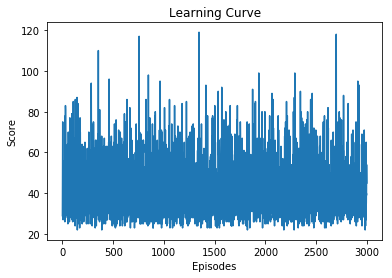

In [15]:
for e in range(3000):
    done = False
    score = 0
    state = env.reset()    # shape=(4,)
    state = np.reshape(state, [1, state_size])    # shape=(1, 4)

    while not done:
        if agent.render:
            env.render()

        # get action for the current state and go one step in environment
        action = agent.get_action(state)
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
#         reward = reward if not done or score == 499 else -100

        # save the sample <s, a, r> to the memory
        agent.append_sample(state, action, reward)

        score += reward
        state = next_state

        if done:
            # every episode, agent learns from sample returns
            agent.train_model(e, 10)

            # every episode, plot the play time
#             score = score if score == 500 else score + 100
            scores.append(score)
            print("episode:", e+1, "  score:", score)

            # if the mean of scores of last 10 episode is bigger than 490
            # stop training
#             if np.mean(scores[-min(10, len(scores)):]) > 490:
#                 sys.exit()
# Plot Result
plt.plot(scores)
plt.xlabel("Episodes")
plt.ylabel("Score")
plt.title("Learning Curve")
plt.show()